# Setup

In [8]:
!pip install graphviz

# Constants

In [9]:
#
# Constants
#  
COLAB = False              # False = local run, True = Google Colab run

#
# check if we're running Google Colab or not
#
if (COLAB):

  import google
  google.colab.drive.mount('/content/drive', force_remount=True)
  
  ROOT_DIR = '/content/drive/MyDrive/google_colab/Comp Theory/TuringMachine'

else:
  ROOT_DIR = '/Users/pworthjr/Documents/FAU/Comp Theory/Assignment 7 (Turing Machines and Linear Bounded Automata)/turing_machine'

CFG_DIR = ROOT_DIR + '/config/'
IMG_DIR = ROOT_DIR + '/img/'


MAX_OPS = 250
DEBUG = True

# TM Classes

The Turing Machine and Tape classes were originally sourced from https://python-course.eu/applications-python/turing-machine.php
although we added support for definitional output and file parsing of transitions among other capabilities

In [10]:
class Tape(object):
    
    #blank_symbol = " "
    
    def __init__(self,
                 tape_string = "",
                 blank_symbol = " ", debug=False):
        
        self.__tape = dict((enumerate(tape_string)))
        
        # last line is equivalent to the following three lines:
        #self.__tape = {}
        #for i in range(len(tape_string)):
        #    self.__tape[i] = input[i]
         
        self.__blank_symbol = blank_symbol
        
        if (debug):
            print('Tape::tape[' + str(self.__tape) + ']')
            print('Tape::blank_symbol[' + str(self.__blank_symbol) + ']')
        
        
    def get_blank_symbol(self):
        return self.__blank_symbol
    
    def __str__(self):
        s = ""
        min_used_index = min(self.__tape.keys()) 
        max_used_index = max(self.__tape.keys())
        for i in range(min_used_index, max_used_index+1):
            s += self.__tape[i]
        return s    
   
    def __getitem__(self,index):
        if index in self.__tape:
            return self.__tape[index]
        else:
            return self.__blank_symbol

    def __setitem__(self, pos, char):
        self.__tape[pos] = char 

In [11]:
import string
import graphviz
from IPython.display import Image, display


class TuringMachine(object):
    
  def __init__(self, 
                tape = "", 
                blank_symbol = " ",
                Sigma = " ",
                Gamma = " ",
                states = None,
                initial_state = "",
                final_states = None,
                transition_file = None,
                transition_function = None):
                
    self.__tape = Tape(
       tape_string=tape, 
       blank_symbol=blank_symbol, 
       debug=True)
    
    self.__head_position = 0
    self.__blank_symbol = blank_symbol
    
    self.__Sigma = Sigma
    self.__Gamma = Gamma
    
    self.__states = states
    self.__initial_state = initial_state
    self.__current_state = initial_state
    
    if (transition_function == None):
        self.read_transition_rules(transition_file)
    else:
        self.__transition_function = transition_function
    
    if final_states == None:
        self.__final_states = set()
    else:
        self.__final_states = set(final_states)
        

  def get_tape(self): 
    return str(self.__tape)

  def get_tape_blank(self):
     return self.__tape.get_blank_symbol()

  def final(self):
    if self.__current_state in self.__final_states:
        #print('Accepting')
        return True
    else:
        #print('Not Acceping')
        return False
    

  def step(self, debug=False):

    char_under_head = self.__tape[self.__head_position]
    x = (self.__current_state, char_under_head)
    
    if x in self.__transition_function:
        y = self.__transition_function[x]

        if (debug):
          print('transition function: ' + str(x) + ' -> ' + str(y))
          print("tape before operation: " + self.get_tape() + '; [head_pos: ' + str(self.__head_position) + ']')
    
        self.__tape[self.__head_position] = y[1]
        if y[2] == "R":
            self.__head_position += 1
        elif y[2] == "L":
            self.__head_position -= 1
        self.__current_state = y[0]
    else:
       if (debug):
          print('*** WARNING: ' + str(x) + ' not in transition function set ***')
          return False

    if (debug):
      print("tape after operation: " + self.get_tape() + '; [head_pos: ' + str(self.__head_position) + ']')
      print('---------------------------------------------------------')
      
    return True
  
  
  #
  # computes the input_str with a max_ops value as input 
  #
  def compute(self, input_string=None, max_ops=MAX_OPS, debug=False):

    self.__tape = Tape(
       tape_string=input_string, 
       blank_symbol=self.__blank_symbol
       )
    
    if (debug):
       print('TuringMachine::compute(tape=' + self.get_tape() + ', blank_symbol=' + str(self.get_tape_blank()) + ')')
       print('---------------------------------------------------------')

    ops = 0
    while not self.final():
      valid_state = self.step(debug=debug)
      ops += 1

      if not valid_state:
        print('*** not a valid state, therefore not accepting ***')
        return False

      if (ops >= max_ops):
        if (debug):
          print('*** WARNING: not accepting after max_ops('+str(ops)+') operations ***')
        return False
    
    if (debug):
       print("ACCEPTING after " + str(ops) + ' operations.')
       print("TM Tape Output: " + self.get_tape())    

    return True


  #
  # support function for parsing transitions from file
  #
  def split_equation(self, text):
    parts = text.split("=")
    lhs = parts[0].strip()
    rhs = parts[1].strip()
    return lhs, rhs
  

  #
  # support function for parsing transitions from file
  #
  def parse_transition_rule(self, rule):
    
    # Remove whitespace and split into components
    rule = rule.strip().replace(" ", "").replace("δ", "").replace("{", "").replace("}", "")

    lhs, rhs = self.split_equation(rule)    

    lhs = lhs.replace('(', '').replace(')', '')
    rhs = rhs.replace('(', '').replace(')', '')

    # Extract state and symbol from strings
    q, sym = lhs.split(',')
    q_next, sym_next, direction = rhs.split(',')
    
    return (q, sym), (q_next, sym_next, direction)
  
  #
  # read transition rules from file
  # takes filename as input, returns rules
  # 
  def read_transition_rules(self, filename):
    
    rules = {}
    transitions = []
    
    with open(filename, "r") as f:
        for line in f:
            if line.strip() != "":
                key, value = self.parse_transition_rule(line)
                rules[key] = value

    self.__transition_function = rules

        

  def get_transitions(self):
     return self.get_transitions_from_transition_function()
  

  def get_transition_function(self):
     return self.__transition_function


  def print(self):
    print("--------------- ** TM Definition ** ---------------")
    print("Q = {" + ", ".join(self.__states) + "}")
    print("Σ = {" + ", ".join(self.__Sigma) + "}")
    print("Γ = {" + ", ".join(self.__Gamma) + "}")
    print("δ : ")
    for key, val in self.__transition_function.items():
        print('   δ'+str(key)+' = {'+str(val)+ str('}'))
    print("q0 = " + self.__initial_state)
    print("b = " + self.__blank_symbol)
    print("F = {" + ", ".join(self.__final_states) + "}")
    print("---------------------------------------------------")


  def get_transitions_from_transition_function(self):
    return [(k[0], k[1], v[1], v[2], v[0]) for k, v in self.__transition_function.items()]

     
  def draw(self, output_file=None):

    transitions = self.get_transitions_from_transition_function()
    
    # Extract the start and end states from the transitions
    start_states = list(set([transition[0] for transition in transitions]))
    end_states = list(set([transition[-1] for transition in transitions]))
    states = list(set(start_states + end_states))

    # Create a new Graphviz graph
    graph = graphviz.Digraph(graph_attr={'rankdir': 'LR'})

    # Add the nodes to the graph
    for state in states:
        if state in self.__final_states:
            # Add a double line around the accepting state node
            graph.node(state, shape='doublecircle', fontname="Calibri Italic", fontsize="10")
        else:
            graph.node(state, fontname="Calibri Italic", fontsize="10")

    # Add the transitions to the graph
    for start_state in start_states:
        for end_state in end_states:
            matching_transitions = [transition for transition in transitions if transition[0] == start_state and transition[-1] == end_state]
            if matching_transitions:
                label = "\n".join([f"({transition[1]}, {transition[2]}, {transition[3]})" for transition in matching_transitions])
                graph.edge(start_state, end_state, label=label, fontname="Calibri Italic", fontsize="10")
    
    if (output_file == None):
      # Render the graph to a byte string
      graph_bytes = graph.pipe(format='png', renderer='cairo')

      # Display the image in the output
      display(Image(graph_bytes))
    else:
      # Render the graph to a PNG file
      graph.render(output_file, format='png', view=True)


# Examples

## Initialize TM in Code

In [12]:
states = {"init", "final"}
Sigma = {"1", "0"}
Gamma = {"1", "0", "□"}

initial_state = "init",

accepting_states = ["final"],

transition_function = {("init","0"):("init", "1", "R"),
                       ("init","1"):("init", "0", "R"),
                       ("init","□"):("final","□", "N"),
                       }

final_states = {"final"}

t = TuringMachine(states = states,
                  Gamma = Gamma,
                  Sigma = Sigma,
                  blank_symbol="□",
                  initial_state = "init",
                  final_states = final_states,
                  transition_function=transition_function)

t.print()

if (t.compute("010011001□", debug=DEBUG)):
  print("*** Accepting ***")
else:
  print('*** Not Accepting ***')  
    

Tape::tape[{}]
Tape::blank_symbol[□]
--------------- ** TM Definition ** ---------------
Q = {init, final}
Σ = {0, 1}
Γ = {0, 1, □}
δ : 
   δ('init', '0') = {('init', '1', 'R')}
   δ('init', '1') = {('init', '0', 'R')}
   δ('init', '□') = {('final', '□', 'N')}
q0 = init
b = □
F = {final}
---------------------------------------------------
TuringMachine::compute(tape=010011001□, blank_symbol=□)
---------------------------------------------------------
transition function: ('init', '0') -> ('init', '1', 'R')
tape before operation: 010011001□; [head_pos: 0]
tape after operation: 110011001□; [head_pos: 1]
---------------------------------------------------------
transition function: ('init', '1') -> ('init', '0', 'R')
tape before operation: 110011001□; [head_pos: 1]
tape after operation: 100011001□; [head_pos: 2]
---------------------------------------------------------
transition function: ('init', '0') -> ('init', '1', 'R')
tape before operation: 100011001□; [head_pos: 2]
tape after oper

In [13]:
t.get_transition_function()

{('init', '0'): ('init', '1', 'R'),
 ('init', '1'): ('init', '0', 'R'),
 ('init', '□'): ('final', '□', 'N')}

In [14]:
t.get_transitions()

[('init', '0', '1', 'R', 'init'),
 ('init', '1', '0', 'R', 'init'),
 ('init', '□', '□', 'N', 'final')]

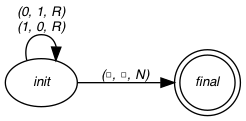

In [15]:
t.draw()

## TM from File

### L = L(*a*\**b*\*)

In [16]:
#
# From Module 10 slides:
# For the alphabet (Sigma) = {a, b} design a Turing machine 
# that accepts the language denoted by the regular expression 'a*b*'
#
states = {"q0", "q1"}
Sigma = {"1", "0"}
Gamma = {"1", "0", "□"}

initial_state = "q0",
accepting_states = ["q1"]

final_states = {"q1"}

t = TuringMachine(states=states,
                  Sigma=Sigma,
                  Gamma=Gamma,
                  initial_state="q0",
                  blank_symbol="□",
                  final_states=final_states,
                  transition_file=CFG_DIR + '/tm10.1_v2.tm')

t.print()

if (t.compute("abbbbbb□", debug=DEBUG)):
  print("*** Accepting ***")
else:
  print('*** Not Accepting ***')
    

Tape::tape[{}]
Tape::blank_symbol[□]
--------------- ** TM Definition ** ---------------
Q = {q0, q1}
Σ = {0, 1}
Γ = {0, 1, □}
δ : 
   δ('q0', 'a') = {('q0', 'a', 'R')}
   δ('q0', 'b') = {('q0', 'b', 'R')}
   δ('q0', '□') = {('q1', '□', 'R')}
q0 = q0
b = □
F = {q1}
---------------------------------------------------
TuringMachine::compute(tape=abbbbbb□, blank_symbol=□)
---------------------------------------------------------
transition function: ('q0', 'a') -> ('q0', 'a', 'R')
tape before operation: abbbbbb□; [head_pos: 0]
tape after operation: abbbbbb□; [head_pos: 1]
---------------------------------------------------------
transition function: ('q0', 'b') -> ('q0', 'b', 'R')
tape before operation: abbbbbb□; [head_pos: 1]
tape after operation: abbbbbb□; [head_pos: 2]
---------------------------------------------------------
transition function: ('q0', 'b') -> ('q0', 'b', 'R')
tape before operation: abbbbbb□; [head_pos: 2]
tape after operation: abbbbbb□; [head_pos: 3]
----------------

In [17]:
t.get_transitions()

[('q0', 'a', 'a', 'R', 'q0'),
 ('q0', 'b', 'b', 'R', 'q0'),
 ('q0', '□', '□', 'R', 'q1')]

In [18]:
trans_funct = t.get_transition_function()

In [19]:
trans_funct

{('q0', 'a'): ('q0', 'a', 'R'),
 ('q0', 'b'): ('q0', 'b', 'R'),
 ('q0', '□'): ('q1', '□', 'R')}

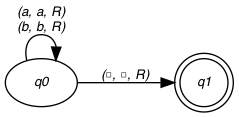

In [20]:
#t.draw(output_file=CFG_DIR + '/test.png')
t.draw()

### L = L(00\*)

In [21]:
#
# From Module 10 slides:
# For the alphabet (Sigma) = {0, 1} design a Turing machine 
# that accepts the language denoted by the regular expression '00*'
#
states = {"q0", "q1"}
Sigma = {"1", "0"}
Gamma = {"1", "0", "□"}

initial_state = "q0",
accepting_states = ["q1"]

final_states = {"q1"}

t = TuringMachine(states=states,
                  Gamma=Gamma,
                  Sigma=Sigma,
                  initial_state = "q0",
                  final_states = final_states,
                  blank_symbol="□",
                  transition_file=CFG_DIR + '/tm10.2_v2.tm')

t.print()

if (t.compute("000000000000000□", debug=DEBUG)):
  print("*** Accepting ***")
else:
  print('*** Not Accepting ***')
    

Tape::tape[{}]
Tape::blank_symbol[□]
--------------- ** TM Definition ** ---------------
Q = {q0, q1}
Σ = {0, 1}
Γ = {0, 1, □}
δ : 
   δ('q0', '0') = {('q0', '0', 'R')}
   δ('q0', '□') = {('q1', '□', 'L')}
q0 = q0
b = □
F = {q1}
---------------------------------------------------
TuringMachine::compute(tape=000000000000000□, blank_symbol=□)
---------------------------------------------------------
transition function: ('q0', '0') -> ('q0', '0', 'R')
tape before operation: 000000000000000□; [head_pos: 0]
tape after operation: 000000000000000□; [head_pos: 1]
---------------------------------------------------------
transition function: ('q0', '0') -> ('q0', '0', 'R')
tape before operation: 000000000000000□; [head_pos: 1]
tape after operation: 000000000000000□; [head_pos: 2]
---------------------------------------------------------
transition function: ('q0', '0') -> ('q0', '0', 'R')
tape before operation: 000000000000000□; [head_pos: 2]
tape after operation: 000000000000000□; [head_pos: 

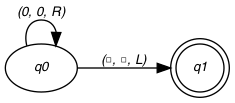

In [22]:
t.draw()

## Assignment 7 (module 10 & 11)

### L = L(*aaba*\**b*)

In [23]:
#
# From Assignment 7a, L = L(aaba*b)
#
states = {"q0", "q1", "q2", "q3", "q4"}
Sigma = {"a", "b"}
Gamma = {"a", "b", "□", "x", "y", "z", "w"}

initial_state = "q0",
accepting_states = ["q4"]

final_states = {"q4"}

t = TuringMachine(states=states,
                  Gamma=Gamma,
                  Sigma=Sigma,
                  initial_state = "q0",
                  final_states = final_states,
                  blank_symbol="□",
                  transition_function=None,
                  transition_file=CFG_DIR + '/assign7_1a_04122023.txt')

t.print()

if (t.compute("aabaaaaaaaaaaaaaaab□", debug=DEBUG)):
    print("*** Accepting ***")
else:
  print('*** Not Accepting ***')

Tape::tape[{}]
Tape::blank_symbol[□]
--------------- ** TM Definition ** ---------------
Q = {q1, q0, q2, q3, q4}
Σ = {b, a}
Γ = {b, w, □, x, z, y, a}
δ : 
   δ('q0', 'a') = {('q1', 'x', 'R')}
   δ('q1', 'a') = {('q2', 'y', 'R')}
   δ('q2', 'b') = {('q3', 'z', 'R')}
   δ('q3', 'a') = {('q3', 'w', 'R')}
   δ('q3', 'b') = {('q4', '□', 'R')}
q0 = q0
b = □
F = {q4}
---------------------------------------------------
TuringMachine::compute(tape=aabaaaaaaaaaaaaaaab□, blank_symbol=□)
---------------------------------------------------------
transition function: ('q0', 'a') -> ('q1', 'x', 'R')
tape before operation: aabaaaaaaaaaaaaaaab□; [head_pos: 0]
tape after operation: xabaaaaaaaaaaaaaaab□; [head_pos: 1]
---------------------------------------------------------
transition function: ('q1', 'a') -> ('q2', 'y', 'R')
tape before operation: xabaaaaaaaaaaaaaaab□; [head_pos: 1]
tape after operation: xybaaaaaaaaaaaaaaab□; [head_pos: 2]
---------------------------------------------------------
tran

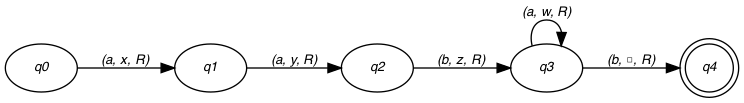

In [24]:
t.draw()

### L = { *w*: |*w*| is a multiple of 4 }

In [25]:
states = {"q0", "q1", "q2", "q3", "q4", "q5"}
Sigma = {"a", "b"}
Gamma = {"a", "b", "□"}

initial_state = "q0"
accepting_states = ["q5"]

final_states = {"q5"}

t = TuringMachine(states=states,
                  Gamma=Gamma,
                  Sigma=Sigma,
                  blank_symbol="□",
                  initial_state = initial_state,
                  final_states = final_states,
                  transition_file=CFG_DIR + '/assign7_1c_04122023.txt')

t.print()

if (t.compute("ababaaaabbba□", debug=DEBUG)):
    print("*** Accepting ***")
else:
  print('*** Not Accepting ***')

Tape::tape[{}]
Tape::blank_symbol[□]
--------------- ** TM Definition ** ---------------
Q = {q5, q0, q4, q2, q3, q1}
Σ = {b, a}
Γ = {b, □, a}
δ : 
   δ('q0', 'a') = {('q1', 'a', 'R')}
   δ('q0', 'b') = {('q1', 'b', 'R')}
   δ('q1', 'a') = {('q2', 'a', 'R')}
   δ('q1', 'b') = {('q2', 'b', 'R')}
   δ('q2', 'a') = {('q3', 'a', 'R')}
   δ('q2', 'b') = {('q3', 'b', 'R')}
   δ('q3', 'a') = {('q4', 'a', 'R')}
   δ('q3', 'b') = {('q4', 'b', 'R')}
   δ('q4', '□') = {('q5', '□', 'R')}
   δ('q4', 'a') = {('q1', 'a', 'R')}
   δ('q4', 'b') = {('q1', 'b', 'R')}
q0 = q0
b = □
F = {q5}
---------------------------------------------------
TuringMachine::compute(tape=ababaaaabbba□, blank_symbol=□)
---------------------------------------------------------
transition function: ('q0', 'a') -> ('q1', 'a', 'R')
tape before operation: ababaaaabbba□; [head_pos: 0]
tape after operation: ababaaaabbba□; [head_pos: 1]
---------------------------------------------------------
transition function: ('q1', 'b') -> ('q

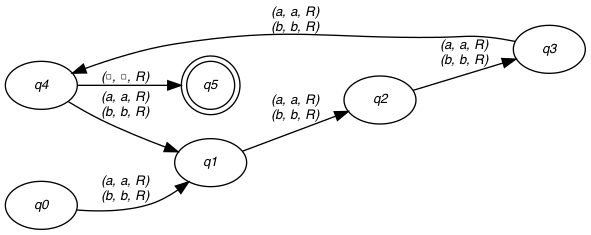

In [26]:
#t.draw(output_file=CFG_DIR + 'png_out.png')
t.draw()

### $$ L = \{ a^nb^ma^{n+m} : n >= 0, m >= 1 \}$$

In [27]:
#
# From Assignment 7, 1f L = {anbman+m: n >= 0, m >=1 }
# annswer from textbook pg 429 (Section 9.1 question 8f)
#
states = {"q0", "q1", "q2", "q3", "q4", "q5", "q6"}
Sigma = {"a", "b"}
Gamma = {"a", "b", "y", "x", "□"}

initial_state = "q0"
accepting_states = ["q6"]

final_states = {"q6"}

t = TuringMachine(states=states,
                  Gamma=Gamma,
                  Sigma=Sigma,
                  blank_symbol="□",
                  initial_state = initial_state,
                  final_states = final_states,
                  transition_file=CFG_DIR + '/assign7_1f_04122023.txt')

t.print()

if (t.compute("abbbbaaaaa□", debug=DEBUG)):
    print("*** Accepting ***")
else:
  print('*** Not Accepting ***')

Tape::tape[{}]
Tape::blank_symbol[□]
--------------- ** TM Definition ** ---------------
Q = {q5, q0, q4, q6, q2, q3, q1}
Σ = {b, a}
Γ = {b, □, x, y, a}
δ : 
   δ('q0', 'b') = {('q1', 'b', 'L')}
   δ('q0', 'a') = {('q1', 'b', 'R')}
   δ('q1', 'a') = {('q1', 'b', 'R')}
   δ('q1', 'b') = {('q1', 'b', 'L')}
   δ('q1', '□') = {('q2', '□', 'R')}
   δ('q2', 'b') = {('q3', 'y', 'R')}
   δ('q2', 'x') = {('q5', 'x', 'R')}
   δ('q3', 'x') = {('q3', 'x', 'R')}
   δ('q3', 'b') = {('q3', 'b', 'R')}
   δ('q3', 'a') = {('q4', 'x', 'L')}
   δ('q4', 'b') = {('q4', 'b', 'L')}
   δ('q4', 'x') = {('q4', 'x', 'L')}
   δ('q4', 'y') = {('q2', 'y', 'R')}
   δ('q5', 'x') = {('q5', 'x', 'R')}
   δ('q5', '□') = {('q6', '□', 'L')}
q0 = q0
b = □
F = {q6}
---------------------------------------------------
TuringMachine::compute(tape=abbbbaaaaa□, blank_symbol=□)
---------------------------------------------------------
transition function: ('q0', 'a') -> ('q1', 'b', 'R')
tape before operation: abbbbaaaaa□; [head_po

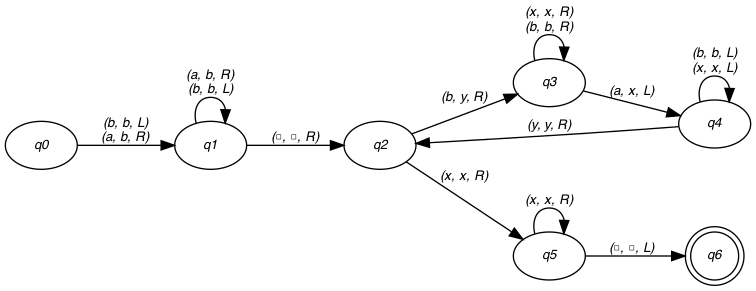

In [28]:
t.draw()

### L = { *ww* : w ϵ {*a*, *b*}\+ }

In [29]:
#
# From Assignment 7, 2 L = {ww : w is in {a, b}+}
#
states = {"q0", "q1", "q2", "q3"}
Sigma = {"a", "b"}
Gamma = {"a", "b", "□"}

initial_state = "q0"
accepting_states = ["q3"]

final_states = {"q3"}

t = TuringMachine(states=states,
                  Gamma=Gamma,
                  Sigma=Sigma,
                  blank_symbol="□",
                  initial_state = initial_state,
                  final_states = final_states,
                  transition_file=CFG_DIR + '/assign7_2_04162023.txt')

t.print()

if (t.compute("aabb□", debug=DEBUG)):
    print("*** Accepting ***")
else:
  print('*** Not Accepting ***')

Tape::tape[{}]
Tape::blank_symbol[□]
--------------- ** TM Definition ** ---------------
Q = {q2, q3, q0, q1}
Σ = {b, a}
Γ = {b, □, a}
δ : 
   δ('q0', 'a') = {('q1', 'a', 'R')}
   δ('q0', 'b') = {('q1', 'b', 'R')}
   δ('q1', 'a') = {('q2', 'a', 'R')}
   δ('q1', 'b') = {('q2', 'b', 'R')}
   δ('q2', 'a') = {('q2', 'a', 'R')}
   δ('q2', 'b') = {('q2', 'b', 'R')}
   δ('q2', '□') = {('q3', '□', 'R')}
q0 = q0
b = □
F = {q3}
---------------------------------------------------
TuringMachine::compute(tape=aabb□, blank_symbol=□)
---------------------------------------------------------
transition function: ('q0', 'a') -> ('q1', 'a', 'R')
tape before operation: aabb□; [head_pos: 0]
tape after operation: aabb□; [head_pos: 1]
---------------------------------------------------------
transition function: ('q1', 'a') -> ('q2', 'a', 'R')
tape before operation: aabb□; [head_pos: 1]
tape after operation: aabb□; [head_pos: 2]
---------------------------------------------------------
transition function: 

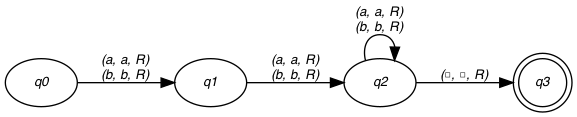

In [30]:
t.draw()

### *f*(*w*) = $w^R$, where *w* ϵ {0, 1}$^+$

In [31]:
#
# From Assignment 7, 3: construct a Turing Machine to 
# compute the function f(w) = wR
#
states = {"q0", "q1"}
Sigma = {"0", "1"}
Gamma = {"0", "1", "□"}

initial_state = "q0"
accepting_states = ["q1"]

final_states = {"q1"}

t = TuringMachine(states=states,
                  Gamma=Gamma,
                  Sigma=Sigma,
                  blank_symbol="□",
                  initial_state = initial_state,
                  final_states = final_states,
                  transition_file=CFG_DIR + '/assign7_3_04162023.txt')

t.print()

if (t.compute("0101010101□", debug=DEBUG)):
    print("*** Accepting ***")
else:
  print('*** Not Accepting ***')

Tape::tape[{}]
Tape::blank_symbol[□]
--------------- ** TM Definition ** ---------------
Q = {q0, q1}
Σ = {0, 1}
Γ = {0, 1, □}
δ : 
   δ('q0', '1') = {('q0', '0', 'R')}
   δ('q0', '0') = {('q0', '1', 'R')}
   δ('q0', '□') = {('q1', '□', 'R')}
q0 = q0
b = □
F = {q1}
---------------------------------------------------
TuringMachine::compute(tape=0101010101□, blank_symbol=□)
---------------------------------------------------------
transition function: ('q0', '0') -> ('q0', '1', 'R')
tape before operation: 0101010101□; [head_pos: 0]
tape after operation: 1101010101□; [head_pos: 1]
---------------------------------------------------------
transition function: ('q0', '1') -> ('q0', '0', 'R')
tape before operation: 1101010101□; [head_pos: 1]
tape after operation: 1001010101□; [head_pos: 2]
---------------------------------------------------------
transition function: ('q0', '0') -> ('q0', '1', 'R')
tape before operation: 1001010101□; [head_pos: 2]
tape after operation: 1011010101□; [head_pos

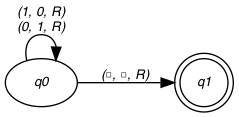

In [32]:
t.draw()